<a href="https://colab.research.google.com/github/Nathan-Ketterlinus/LorenzDNN/blob/main/Lorenz_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install deepxde
import deepxde as dde

Generating reference solution 0/1000
Generating reference solution 100/1000
Generating reference solution 200/1000
Generating reference solution 300/1000
Generating reference solution 400/1000
Generating reference solution 500/1000
Generating reference solution 600/1000
Generating reference solution 700/1000
Generating reference solution 800/1000
Generating reference solution 900/1000


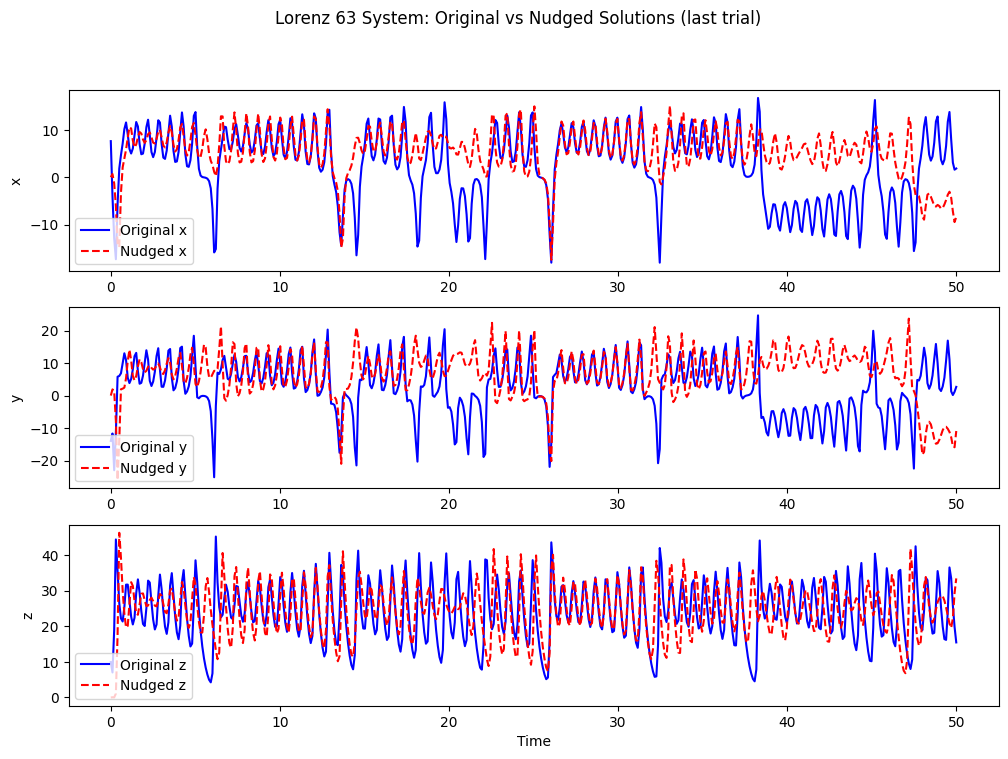

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

class Lorenz63:
    def __init__(self, sigma=10.0, rho=28.0, beta=8/3):
        self.sigma = sigma
        self.rho = rho
        self.beta = beta

    def original_system(self, state, t):
        x, y, z = state

        # system equations
        dxdt = self.sigma * (y - x)
        dydt = x * (self.rho - z) - y
        dzdt = x * y - self.beta * z

        return [dxdt, dydt, dzdt]

    def nudged_system(self, state, t, x_observed, mu):
        x_bar, y_bar, z_bar = state

        # Get the observed x value at time t (needs interpolation)
        x = np.interp(t, x_observed[:, 0], x_observed[:, 1])

        # system equations
        dxdt_bar = self.sigma * (y_bar - x_bar) - mu * (x_bar - x) # with nudging term!
        dydt_bar = x_bar * (self.rho - z_bar) - y_bar
        dzdt_bar = x_bar * y_bar - self.beta * z_bar

        return [dxdt_bar, dydt_bar, dzdt_bar]

def simulate_lorenz_with_nudging():
    # Parameters
    sigma = 10.0
    rho = 28.0
    beta = 8/3
    mu = 30  # Nudging parameter

    num_reference_solutions = 1000  # N_s
    final_time = 50  # T, when to stop simulation (in seconds)
    observations_per_second = 10
    observation_times = np.linspace(0, final_time, final_time * observations_per_second) # {t_n}

    input_samples = [] # stores <num_reference_solutions> many (x_bar, y_bar, z_bar, observed x) @ time t
    output_samples = [] # stores <num_reference_solutions> many (x_bar, y_bar, z_bar) @ time t+1

    for i in range(num_reference_solutions):
        # Display progress of generating solutions
        if i % 100 == 0:
            print(f"Generating reference solution {i}/{num_reference_solutions}")

        # Generate random initial conditions
        x0, y0, z0 = np.random.normal(loc=0, scale=10, size=3) # from mean = 0, std dev =10

        # Simulate true system
        lorenz = Lorenz63(sigma, rho, beta)
        true_solution = odeint(lorenz.original_system, [x0, y0, z0], observation_times)

        # Create observations (x-component only)
        x_observed = np.column_stack((observation_times, true_solution[:, 0])) # I_M(u^i(t_k))

        # Simulate nudged system
        nudged_solution = odeint(lorenz.nudged_system, [0, 0, 0], observation_times, args=(x_observed, mu)) # W^i(t_k)

        # Create training pairs (Algorithm 3.1)
        for k in range(len(observation_times) - 1):
            # Input: [w(t_k), I_M(u(t_k))]
            current_state = nudged_solution[k]
            current_obs = x_observed[k, 1]  # x(t_k)
            input_pair = np.concatenate([current_state, [current_obs]])

            # Output: w(t_{k+1})
            next_state = nudged_solution[k + 1]

            input_samples.append(input_pair)
            output_samples.append(next_state)

    # Convert to numpy arrays
    input_data = np.array(input_samples)
    output_data = np.array(output_samples)

    # Plot results
    plt.figure(figsize=(12, 8))

    # Plot x components
    plt.subplot(3, 1, 1)
    plt.plot(observation_times, true_solution[:, 0], 'b-', label='Original x')
    plt.plot(observation_times, nudged_solution[:, 0], 'r--', label='Nudged x')
    plt.ylabel('x')
    plt.legend()

    # Plot y components
    plt.subplot(3, 1, 2)
    plt.plot(observation_times, true_solution[:, 1], 'b-', label='Original y')
    plt.plot(observation_times, nudged_solution[:, 1], 'r--', label='Nudged y')
    plt.ylabel('y')
    plt.legend()

    # Plot z components
    plt.subplot(3, 1, 3)
    plt.plot(observation_times, true_solution[:, 2], 'b-', label='Original z')
    plt.plot(observation_times, nudged_solution[:, 2], 'r--', label='Nudged z')
    plt.ylabel('z')
    plt.xlabel('Time')
    plt.legend()

    plt.suptitle('Lorenz 63 System: Original vs Nudged Solutions (last trial)')
    plt.show()

    return input_data, output_data

# Run the simulation
original, nudged = simulate_lorenz_with_nudging()

timedomain = dde.geometry.TimeDomain(0, 10)

############################################################
# Algorithm 3.2: Online Usage of DNN for Data Assimilation #
############################################################
# 1: Initialize wDNN (t0) = 0 (or arbitrary)               #
# 2: Observe IM (ui(t0))                                   #
# 3: Set k = 0                                             #
# 4: while Observations are available do                   #
# 5:      wDNN (tk+1) = DNN (wDNN (tk), IM (ui(tk))        #
# 6:      Observe IM (ui(tk+1))                            #
# 7:      k = k + 1                                        #
# 8: end while                                             #
############################################################

Observation times from t=100.0 to 110.0 with 101 points
Time between observations: 0.09999999999999432 (should be 0.1)
Generating reference solution for initial condition 0/1000
Generating reference solution for initial condition 100/1000
Generating reference solution for initial condition 200/1000
Generating reference solution for initial condition 300/1000
Generating reference solution for initial condition 400/1000
Generating reference solution for initial condition 500/1000
Generating reference solution for initial condition 600/1000
Generating reference solution for initial condition 700/1000
Generating reference solution for initial condition 800/1000
Generating reference solution for initial condition 900/1000


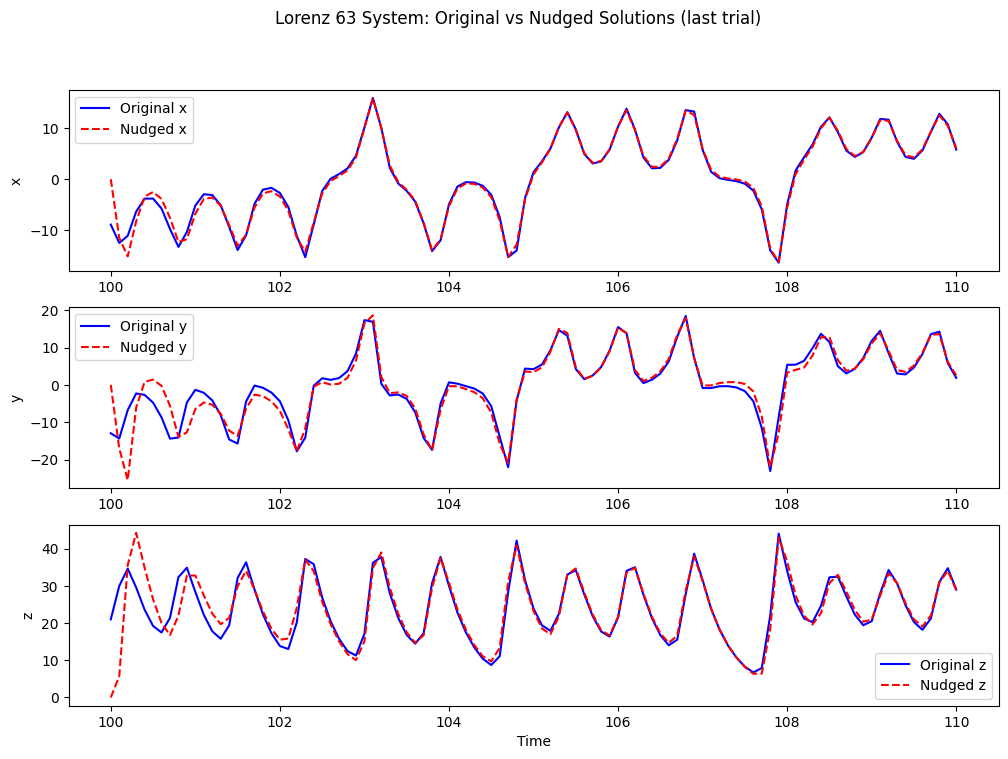


=== Verification ===
Number of initial conditions (Ns): 1000
Observations per simulation: 100 (from 101 time points)
Expected total samples: 100000 (Ns × 100)
Actual input_data shape: (100000, 4) (should be (100000, 4))
Actual output_data shape: (100000, 3) (should be (100000, 3))
Compiling model...
Building residual neural network...


AttributeError: `dense` is not available with Keras 3.

In [ ]:
import deepxde as dde
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

class Lorenz63:
    def __init__(self, sigma=10.0, rho=28.0, beta=8/3):
        self.sigma = sigma
        self.rho = rho
        self.beta = beta

    def original_system(self, state, t):
        x, y, z = state

        # system equations
        dxdt = self.sigma * (y - x)
        dydt = x * (self.rho - z) - y
        dzdt = x * y - self.beta * z

        return [dxdt, dydt, dzdt]

    def nudged_system(self, state, t, x_observed, mu):
        x_bar, y_bar, z_bar = state

        # Get the observed x value at time t (needs interpolation)
        x = np.interp(t, x_observed[:, 0], x_observed[:, 1])

        # system equations
        dxdt_bar = self.sigma * (y_bar - x_bar) - mu * (x_bar - x) # with nudging term!
        dydt_bar = x_bar * (self.rho - z_bar) - y_bar
        dzdt_bar = x_bar * y_bar - self.beta * z_bar

        return [dxdt_bar, dydt_bar, dzdt_bar]

def simulate_lorenz_with_nudging():
    # Parameters
    sigma = 10.0
    rho = 28.0
    beta = 8/3
    mu = 30  # Nudging parameter

    num_reference_solutions = 1000  # N_s
    total_simulation_time = 110  # Simulate up to t=110
    observation_start_time = 100  # Start recording observations at t=100
    observations_per_time_unit = 10  # δ = 0.1 time units between observations
    delta_t = 1.0/observations_per_time_unit  # 0.1

    # Create observation times (from 100 to 110, every 0.1 units)
    num_observations = int((total_simulation_time - observation_start_time) / delta_t) + 1
    observation_times = np.linspace(observation_start_time, total_simulation_time, num_observations)

    # Verify observation times
    print(f"Observation times from t={observation_times[0]} to {observation_times[-1]} with {len(observation_times)} points")
    print(f"Time between observations: {observation_times[1] - observation_times[0]} (should be {delta_t})")

    # Full simulation times (from 0 to 110 - needed for the ODE solver)
    full_simulation_times = np.linspace(0, total_simulation_time,
                                       int(total_simulation_time * observations_per_time_unit) + 1)

    input_samples = [] # stores (x_bar, y_bar, z_bar, observed x) @ time t
    output_samples = [] # stores (x_bar, y_bar, z_bar) @ time t+1

    for i in range(num_reference_solutions):
        # Display progress of generating solutions
        if i % 100 == 0:
            print(f"Generating reference solution for initial condition {i}/{num_reference_solutions}")

        # Generate random initial conditions from N(0, 10)
        x0, y0, z0 = np.random.normal(loc=0, scale=10, size=3)

        # Simulate true system from t=0 to t=110
        lorenz = Lorenz63(sigma, rho, beta)
        true_solution = odeint(lorenz.original_system, [x0, y0, z0], full_simulation_times)

        # Extract only the observation period (t=100 to t=110)
        obs_indices = (full_simulation_times >= observation_start_time)
        observed_times = full_simulation_times[obs_indices]
        observed_states = true_solution[obs_indices]

        # Verify we have correct number of observation points
        assert len(observed_times) == num_observations, \
               f"Expected {num_observations} observations, got {len(observed_times)}"

        # Create observations (x-component only) during observation period
        x_observed = np.column_stack((observed_times, observed_states[:, 0]))

        # Simulate nudged system during observation period only
        nudged_solution = odeint(lorenz.nudged_system, [0, 0, 0], observed_times, args=(x_observed, mu))

        # Create training pairs (Algorithm 3.1)
        for k in range(len(observed_times) - 1):
            # Input: [w(t_k), I_M(u(t_k))]
            current_state = nudged_solution[k]
            current_obs = x_observed[k, 1]  # x(t_k)
            input_pair = np.concatenate([current_state, [current_obs]])

            # Output: w(t_{k+1})
            next_state = nudged_solution[k + 1]

            input_samples.append(input_pair)
            output_samples.append(next_state)

    # Convert to numpy arrays
    input_data = np.array(input_samples)
    output_data = np.array(output_samples)

    # Plot results
    plt.figure(figsize=(12, 8))

    # Extract the portion of true_solution corresponding to observation_times
    true_solution_obs_period = true_solution[obs_indices]

    # Plot x components
    plt.subplot(3, 1, 1)
    plt.plot(observation_times, true_solution_obs_period[:, 0], 'b-', label='Original x')
    plt.plot(observation_times, nudged_solution[:, 0], 'r--', label='Nudged x')
    plt.ylabel('x')
    plt.legend()

    # Plot y components
    plt.subplot(3, 1, 2)
    plt.plot(observation_times, true_solution_obs_period[:, 1], 'b-', label='Original y')
    plt.plot(observation_times, nudged_solution[:, 1], 'r--', label='Nudged y')
    plt.ylabel('y')
    plt.legend()

    # Plot z components
    plt.subplot(3, 1, 3)
    plt.plot(observation_times, true_solution_obs_period[:, 2], 'b-', label='Original z')
    plt.plot(observation_times, nudged_solution[:, 2], 'r--', label='Nudged z')
    plt.ylabel('z')
    plt.xlabel('Time')
    plt.legend()

    plt.suptitle('Lorenz 63 System: Original vs Nudged Solutions (last trial)')
    plt.show()

    # Verification
    print("\n=== Verification ===")
    print(f"Number of initial conditions (Ns): {num_reference_solutions}")
    print(f"Observations per simulation: {num_observations - 1} (from {num_observations} time points)")
    expected_total_samples = num_reference_solutions * (num_observations - 1)
    print(f"Expected total samples: {expected_total_samples} (Ns × {num_observations - 1})")
    print(f"Actual input_data shape: {input_data.shape} (should be ({expected_total_samples}, 4))")
    print(f"Actual output_data shape: {output_data.shape} (should be ({expected_total_samples}, 3))")

    assert input_data.shape == (expected_total_samples, 4), "Input data shape mismatch"
    assert output_data.shape == (expected_total_samples, 3), "Output data shape mismatch"

    return input_data, output_data

# Run the simulation
input_data, output_data = simulate_lorenz_with_nudging()

# crop to just the first N x N_s samples
N = 15
input_data = input_data[:1000 * N] # change N_s to not be a magic number
output_data = output_data[:1000 * N]

# Split into train and validation (80-20)
n_train = int(0.8 * len(input_data))
input_training = input_data[:n_train] # 0-80% of samples for training
output_training = output_data[:n_train]

input_validation = input_data[n_train:] # 80-100% for validation
output_validation = output_data[n_train:]

############################################################
# Algorithm 3.2: Online Usage of DNN for Data Assimilation #
############################################################
# 1: Initialize wDNN (t0) = 0 (or arbitrary)               #
# 2: Observe IM (ui(t0))                                   #
# 3: Set k = 0                                             #
# 4: while Observations are available do                   #
# 5:      wDNN (tk+1) = DNN (wDNN (tk), IM (ui(tk))        #
# 6:      Observe IM (ui(tk+1))                            #
# 7:      k = k + 1                                        #
# 8: end while                                             #
############################################################

# Define the neural network architecture
def create_resnet(num_neurons=50, num_blocks=2):  # num_layers = 2 * num_blocks + 1 # NEED BETTER UNDERSTANDING HERE
    net = dde.nn.ResNet(
        input_size=4,  # [x,y,z,observation]
        output_size=3,  # [x_next,y_next,z_next]
        num_neurons=num_neurons,
        num_blocks=num_blocks,
        activation="swish", # should be Quadratic ReLu
        kernel_initializer="Glorot normal",
        regularization=None  # We'll handle regularization in the loss function
    )
    return net

# Create the network (3-layer ResNet: 1 input + 1 hidden + 1 output)
net = create_resnet(num_neurons=50, num_blocks=1)  # num_blocks=1 creates 3 layers total

# Define the model
model = dde.Model(
    data=dde.data.DataSet(
        input_training,
        output_training,
        input_validation,
        output_validation,
    ),
    net=net,
)

# Compile and train with early stopping
model.compile(
    optimizer="L-BFGS-B", # needs to be BFGS
    loss="MSE", # needs to be RMSE
    metrics=["l2 relative error"],
)

# Early stopping callback
early_stopping = dde.callbacks.EarlyStopping(
    min_delta=1e-5,
    patience=400,
    baseline=None,
    monitor="loss_val",
    restore_best_weights=True,
)

losshistory, train_state = model.train(
    iterations=10000,
    callbacks=[early_stopping],
    display_every=100,
)

# Plot training history
dde.utils.plot_loss_history(losshistory)
plt.show()